### Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

### Load Data

In [8]:
data_path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv'  
df = pd.read_csv(data_path)
df = df.drop(columns=['file', 'Unnamed: 0', 'is_background_encoded'])

### Initialize Data & Split

In [9]:
# set target
target = 'daytime_encoded'  # Zielvariable
X = df.drop(columns=[target])  # Features (alle Spalten außer 'daytime')
y = df[target]  # Zielvariable

# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ausgabe der Größen
print(f"Trainingsdaten: {X_train.shape}, Testdaten: {X_test.shape}")


# 1st split: train/ test 
#X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# 2nd split: train / validation 
#X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)
# TRAIN 60% VAL 20% TEST 20%
#print(f"Trainingsdaten: {X_train.shape}, Validierungsdaten: {X_val.shape}, Testdaten: {X_test.shape}")
# standardize data
#scaler = StandardScaler() 
#X_filtered_scaled = scaler.fit_transform(X)

Trainingsdaten: (6552, 57), Testdaten: (2809, 57)


### Baseline Approach

In [10]:
# initialize model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
random_forest.fit(X_train, y_train)

# results
y_pred = random_forest.predict(X_test)

print("Training Accuracy:", random_forest.score(X_train, y_train))
print("Test Accuracy:", random_forest.score(X_test, y_test))

target_names = ['A', 'M']
print('-'*80)

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names= target_names))
print('-'*80)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print('-'*80)

Training Accuracy: 1.0
Test Accuracy: 0.9558561765752936
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           A       0.95      0.97      0.96      1642
           M       0.96      0.93      0.95      1167

    accuracy                           0.96      2809
   macro avg       0.96      0.95      0.95      2809
weighted avg       0.96      0.96      0.96      2809

--------------------------------------------------------------------------------

Confusion Matrix:
 [[1596   46]
 [  78 1089]]
--------------------------------------------------------------------------------


Baseline of Random Forest shows overfitting, because of 100% training accuracy. Problem solving needed. 

### Tree visualisation to check comlpexity

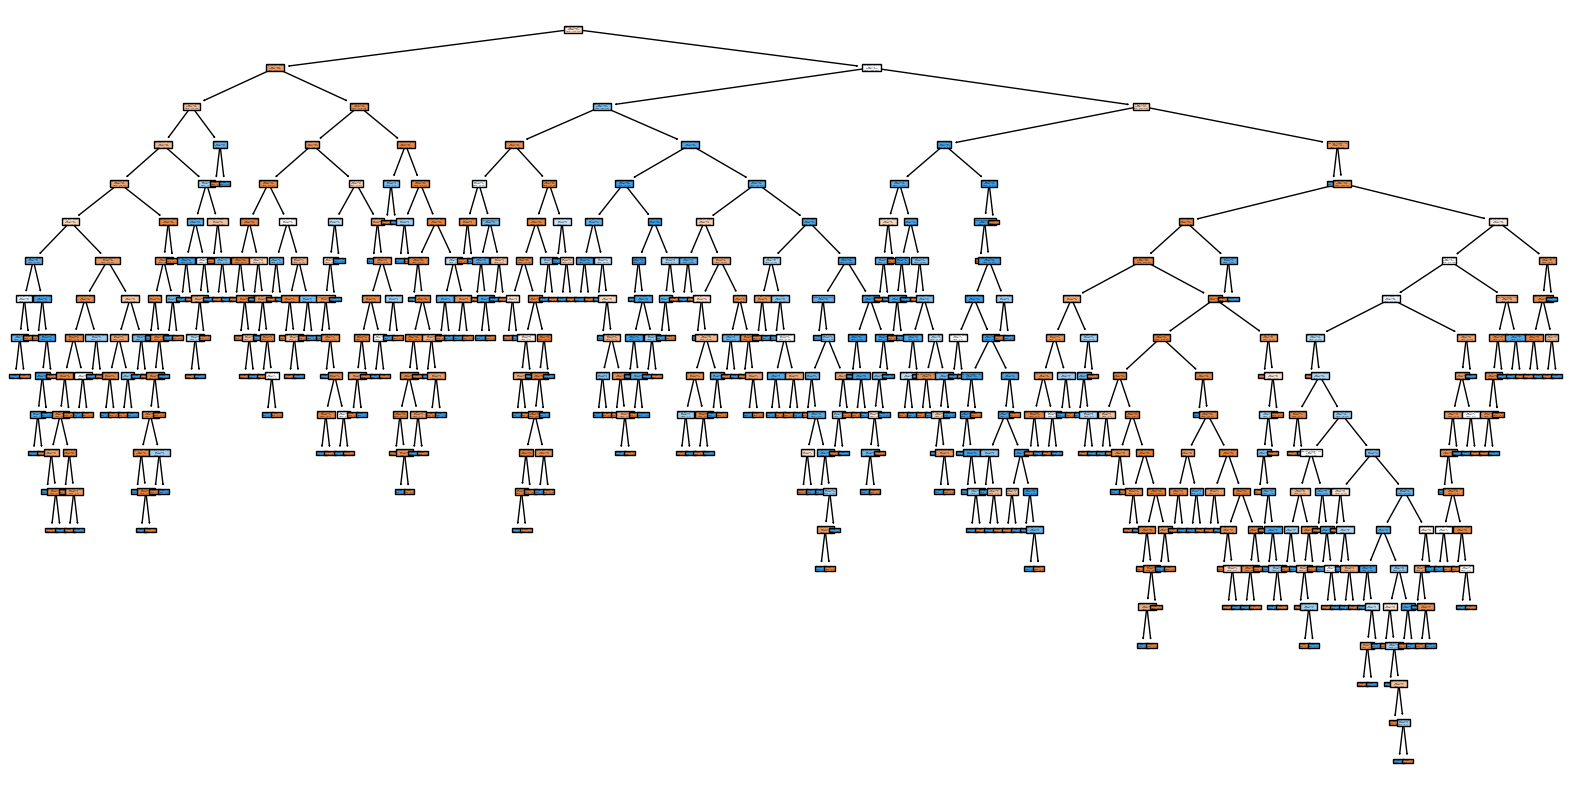

In [6]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Einen Baum plotten
plt.figure(figsize=(20, 10))
plot_tree(random_forest.estimators_[3], feature_names=X_train.columns, filled=True)
plt.show()


### Pipeline with Scaler, Cross Validation

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Schritt 1: Standardisierung
    ('classifier', RandomForestClassifier(random_state=42))  # Schritt 2: Random Forest
])

# Cross-Validation auf den Trainingsdaten
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Pipeline trainieren auf dem gesamten Training-Set
pipeline.fit(X_train, y_train)

# Vorhersagen auf den Testdaten
y_pred = pipeline.predict(X_test)

# Ergebnisse ausgeben
target_names = ['A', 'M']
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("\nTestdaten-Auswertung:")
print(classification_report(y_test, y_pred, target_names= target_names))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Training Accuracy: 1.0
Test Accuracy: 0.9558561765752936
Cross-Validation Accuracy Scores: [0.94584287 0.93897788 0.95267176 0.94580153 0.9519084 ]
Mean CV Accuracy: 0.9470404853820579

Testdaten-Auswertung:
              precision    recall  f1-score   support

           A       0.95      0.97      0.96      1642
           M       0.96      0.93      0.95      1167

    accuracy                           0.96      2809
   macro avg       0.96      0.95      0.95      2809
weighted avg       0.96      0.96      0.96      2809


Confusion Matrix:
 [[1596   46]
 [  78 1089]]


Cross validation improves overfitting problem. It is an indicator against data instability: Large differences in cross-validation scores could indicate data issues, such as an unequal distribution of classes or an imbalance between the folds. The low variance suggests otherwise.

### Learning Curve Approach

In [12]:
# Learning Curve berechnen
train_sizes, train_scores, val_scores = learning_curve(
    random_forest,             # Dein Modell
    X_train,            # Trainingsdaten
    y_train,            # Zielvariable
    cv=5,               # Anzahl der Folds für Cross-Validation
    scoring="accuracy", # Metrik zur Bewertung
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 Stufen von 10% bis 100% der Trainingsdaten
    n_jobs=-1           # Parallelisierung für schnellere Berechnung
)

# Mittelwerte und Standardabweichungen der Scores berechnen
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


### Learning Curve Visualisation

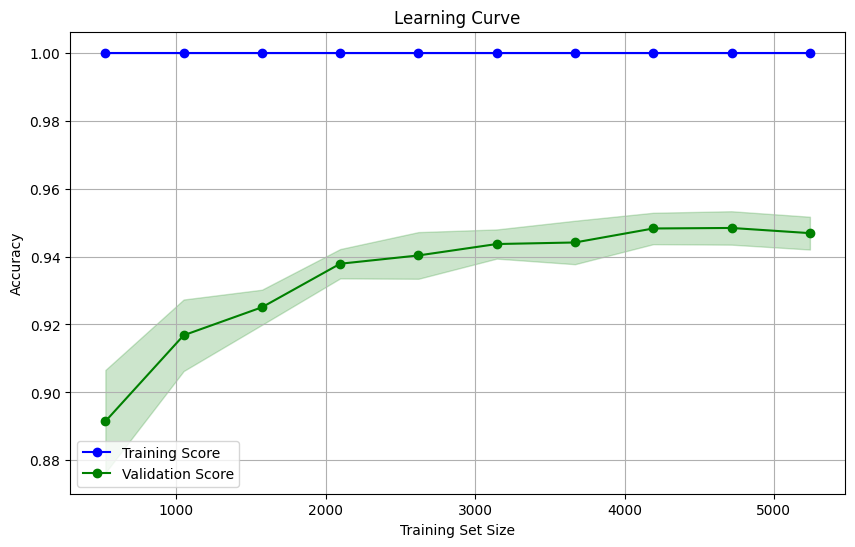

In [13]:
# Plot der Lernkurve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.plot(train_sizes, val_mean, 'o-', color="green", label="Validation Score")

# Fülle die Bereiche für Standardabweichung
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="green")

# Plot-Konfiguration
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


This approach shows, that overfitting is not related to training set size, as test accuracy is constant at 100%. Problem is probably part of the dataset or needs to be adresses by hyperparameter tuning.

### Removal of features with overpowered importance from feature_importance_analysis.ipynb

In [19]:
data_path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv'  
df_improved = pd.read_csv(data_path)
df_improved = df_improved.drop(columns=['file', 'Unnamed: 0', 'is_background_encoded']) 

# drop overpowered features
common_features = pd.read_csv("common_features.csv")
features_to_drop = common_features["Common Features"].tolist()
df_improved = df_improved.drop(columns=features_to_drop, errors="ignore")

# set target
target = 'daytime_encoded'  # Zielvariable
X = df_improved.drop(columns=[target])  # Features (alle Spalten außer 'daytime')
y = df_improved[target]  # Zielvariable

# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ausgabe der Größen
print(f"Trainingsdaten: {X_train.shape}, Testdaten: {X_test.shape}")

Trainingsdaten: (6552, 49), Testdaten: (2809, 49)


Now the overpowered features that were discovered in the importance analysis are dropped before training to reduce overfitting and improve robust generalisation.

### Feature selected Pipeline with Scaler, Cross Validation

In [20]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Schritt 1: Standardisierung
    ('classifier', RandomForestClassifier(random_state=42))  # Schritt 2: Random Forest
])

# Cross-Validation auf den Trainingsdaten
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Pipeline trainieren auf dem gesamten Training-Set
pipeline.fit(X_train, y_train)

# Vorhersagen auf den Testdaten
y_pred = pipeline.predict(X_test)

# Ergebnisse ausgeben
target_names = ['A', 'M']
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("\nTestdaten-Auswertung:")
print(classification_report(y_test, y_pred, target_names= target_names))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Cross-Validation Accuracy Scores: [0.91304348 0.89549962 0.90381679 0.90458015 0.90229008]
Mean CV Accuracy: 0.903846023954676

Testdaten-Auswertung:
              precision    recall  f1-score   support

           A       0.90      0.94      0.92      1642
           M       0.91      0.86      0.88      1167

    accuracy                           0.90      2809
   macro avg       0.90      0.90      0.90      2809
weighted avg       0.90      0.90      0.90      2809


Confusion Matrix:
 [[1538  104]
 [ 167 1000]]


Validation fold (0.9022) is slightly worse than trainings folds, which indicates no overfitting. In general accuracy is slightly worse than before. Indicates less overfitting.

### Hyperparameter tuning with grid search

In [21]:
from sklearn.model_selection import GridSearchCV, cross_val_score


# Pipeline mit StandardScaler und RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Schritt 1: Standardisierung
    ('classifier', RandomForestClassifier(random_state=42))  # Schritt 2: Random Forest
])

# Hyperparameter für GridSearch
param_grid = {
    'classifier__n_estimators': [50, 100, 200],         # Anzahl der Bäume
    'classifier__max_depth': [None, 10, 20, 30],       # Maximale Tiefe der Bäume
    'classifier__min_samples_split': [2, 5, 10],       # Mindestanzahl von Proben, um zu splitten
    'classifier__min_samples_leaf': [1, 2, 4]          # Mindestanzahl an Proben pro Blatt
}

# GridSearchCV mit Cross-Validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                         # Anzahl der Cross-Validation-Folds
    scoring='accuracy',           # Metrik zur Bewertung
    n_jobs=-1,                    # Parallelisierung
    verbose=2                     # Fortschrittsanzeige
)

# GridSearchCV auf die Trainingsdaten anwenden
grid_search.fit(X_train, y_train)

# Beste Hyperparameter und Ergebnis anzeigen
print("Beste Hyperparameter:", grid_search.best_params_)
print("Beste Cross-Validation-Genauigkeit:", grid_search.best_score_)

# Pipeline mit den besten Parametern trainieren
best_pipeline = grid_search.best_estimator_

# Vorhersagen auf den Testdaten
y_pred = best_pipeline.predict(X_test)

# Ergebnisse auf Testdaten ausgeben
target_names = ['A', 'M']
print("\nTestdaten-Auswertung:")
print(classification_report(y_test, y_pred, target_names=target_names))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Beste Hyperparameter: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Beste Cross-Validation-Genauigkeit: 0.904303922767423

Testdaten-Auswertung:
              precision    recall  f1-score   support

           A       0.90      0.94      0.92      1642
           M       0.91      0.86      0.88      1167

    accuracy                           0.90      2809
   macro avg       0.90      0.90      0.90      2809
weighted avg       0.90      0.90      0.90      2809


Confusion Matrix:
 [[1538  104]
 [ 169  998]]
